In [1]:
import numpy as np
import os


from sklearn.linear_model import LinearRegression
from sklearn import mixture, metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from numpy import linalg

from skimage import io
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage.morphology import disk, skeletonize, ball
from skimage import filters
from skimage.morphology import disk
from skimage import transform
from skimage.feature import peak_local_max
import skimage.segmentation as seg

from PIL import Image, ImageDraw, ImageFilter, ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon


from src.utils import grainPreprocess, grainShow, grainMark, grainDraw, grainApprox, grainStats, grainMorphology


## Combine images

In [ ]:
def imdivide(image, side):
    width, height = image.size
    sides = {'left': 0, 'right': 1}
    shape = [(0, 0, width // 2, height), (width // 2, 0, width, height)]
    return image.crop(shape[sides[side]])


In [ ]:
def combine(image, k=0.5, N=20):
    left_img = imdivide(image, 'left')
    right_img = imdivide(image, 'right')

    l = k
    r = 1 - l
    gray = np.array(left_img) * l
    gray += np.array(right_img) * r
    gray = gray.astype('uint8')
    return gray

In [ ]:
c2 = combine(grain2_pil, 0.5, 10)
img_show(c2, 10)

In [ ]:
img_show(grain3)

# Otsu's binarization

In [ ]:
def do_otsu(img, N=20):
    image = rgb2gray(img)

    global_thresh = skimage.filters.threshold_otsu(image)
    binary_global = image > global_thresh

    # ax1.imshow(img,cmap='gray')
    plt.figure(figsize=(N, N))
    plt.imshow(binary_global, cmap='gray')
    plt.show()



In [ ]:

do_otsu(grain3, N=15)

In [ ]:
do_otsu(doggo1, N=7)
do_otsu(coins, 10)

# Watershed 

Обычный метод

In [ ]:
def do_watershed(image, N=20):
    image = rgb2gray(image)

    segmented = seg.watershed(image)
    fig, ax = plt.subplots(ncols=1, figsize=(N, N), sharex=True, sharey=True)

    ax.imshow(segmented, cmap=plt.cm.gray)
    ax.set_title('segmented')

    plt.show()


In [ ]:
do_watershed(grain1, 10)
#do_watershed(grain2,10)
#do_watershed(grain3,10)

Сегментация с маркерами edt (Euclidean Distance Transform)

In [ ]:
def do_watershed_edt(image, N=50):
    image = rgb2gray(image)
    global_thresh = skimage.filters.threshold_otsu(image)
    bin_image = image > global_thresh

    distance = ndi.distance_transform_edt(bin_image)
    distance_copy = copy.copy(distance)

    coords = peak_local_max(distance_copy, footprint=np.ones((3, 3)), labels=image.astype('int32')).astype('int64')

    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)

    labels = seg.watershed(-distance, markers, mask=image)
    labels = labels.astype('uint8')

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')

    ax[1].imshow(bin_image, cmap=plt.cm.gray)
    ax[1].set_title('binary image')

    ax[2].imshow(distance, cmap=plt.cm.gray)
    ax[2].set_title('Distances')

    ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[3].set_title('Separated objects')

#plt.show()

In [ ]:
do_watershed_edt(doggo1, 2)

Сегментация с гранидентыми маркерами

In [ ]:
def do_watershed_grad(image, N=20):
    image = rgb2gray(image)
    #denoised=image
    denoised = filters.rank.median(image, disk(3))
    #denoised =  filters.rank.equalize(image, disk(50))
    #denoised = exposure.equalize_hist(image/255)

    # find continuous region (low gradient -
    # where less than 10 for this image) --> markers
    # disk(5) is used here to get a more smooth image
    markers = filters.rank.gradient(denoised, disk(8)) < 40
    markers = ndi.label(markers)[0]

    # local gradient (disk(2) is used to keep edges thin)
    gradient = filters.rank.gradient(denoised, disk(1))

    # process the watershed
    labels = seg.watershed(gradient, markers)

    # display results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("Original")

    ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
    ax[1].set_title("Gradient")

    ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
    ax[2].set_title("Markers")

    ax[3].imshow(image, cmap=plt.cm.gray)
    ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
    ax[3].set_title("Segmented")


    fig.tight_layout()
    plt.show()

In [ ]:
do_watershed_grad(grain3)

## Rank filters
https://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html#sphx-glr-auto-examples-applications-plot-rank-filters-py

In [ ]:
denoised4 = filters.rank.autolevel_percentile(grain1, selem=disk(5), p0=.2, p1=.9)
N = 20
plt.figure(figsize=(N, N))
io.imshow(denoised4, cmap=plt.cm.gray)

In [ ]:
denoised4 = filters.rank.enhance_contrast(grain2, disk(2))
N = 20
plt.figure(figsize=(N, N))
io.imshow(denoised4, cmap=plt.cm.gray)

In [ ]:
denoised4 = filters.rank.enhance_contrast(image, disk(2))
denoised5 = filters.rank.gradient(grain1, disk(1))
N = 20
plt.figure(figsize=(N, N))
io.imshow(denoised5, cmap=plt.cm.gray)

In [ ]:
#denoised5 = filters.rank.entropy(image, disk(2))
denoised5 = filters.rank.equalize(image, disk(100))
N = 20
plt.figure(figsize=(N, N))
io.imshow(denoised5, cmap=plt.cm.gray)

In [ ]:
image = rgb2gray(grain2)
# denoise image
denoised1 = filters.rank.median(image, disk(3))
denoised2 = exposure.equalize_hist(image / 255)
denoised3 = filters.rank.equalize(image, disk(100))
denoised4 = filters.rank.autolevel_percentile(image, selem=disk(20), p0=.2, p1=.7)

N = 30

fig, axes = plt.subplots(nrows=5, figsize=(N, N),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[1].imshow(denoised1, cmap=plt.cm.gray)
ax[2].imshow(denoised2, cmap=plt.cm.gray)
ax[3].imshow(denoised3, cmap=plt.cm.gray)
ax[4].imshow(denoised4, cmap=plt.cm.gray)

plt.show()

# Floodfill


In [ ]:
def do_floodfill(image, N=50):
    # Fill a square near the middle with value 127, starting at index (76, 76)
    filled_checkers = flood_fill(image, (76, 76), 127)

    fig, ax = plt.subplots(nrows=2, figsize=(N, N))

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')

    ax[1].imshow(filled_checkers, cmap=plt.cm.gray)
    ax[1].plot(76, 76, 'wo')  # seed point
    ax[1].set_title('After flood fill')

    plt.show()

In [ ]:
do_floodfill(grain2, N=20)

# K-means

In [ ]:
def do_kmeans(image, N=20, n_segments=100, compactness=10, cmap=plt.cm.gray):
    segments = seg.slic(image, n_segments, compactness)
    fig, ax = plt.subplots(nrows=1, figsize=(N, N))

    ax.imshow(segments, cmap=cmap)
    ax.plot(76, 76, 'wo')  # seed point
    ax.set_title('k-means')

    plt.show()

In [ ]:
do_kmeans(grain1, N=15, n_segments=300, compactness=5, cmap=plt.cm.nipy_spectral)

In [ ]:
do_kmeans(grain2, 15, 500)

# Felzenszwalb

In [ ]:
def do_felzen(image, N=20):
    img = img_as_float(image)
    segments_fz = seg.felzenszwalb(img, scale=100, sigma=0.5, min_size=50)

    print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")

    fig, ax = plt.subplots(nrows=1, figsize=(N, N), sharex=True, sharey=True)
    felz = seg.mark_boundaries(img, segments_fz)
    ax.imshow(felz)
    ax.set_title("Felzenszwalbs's method")
    plt.tight_layout()
    plt.show()
    return felz

In [ ]:
felz = do_felzen(grain2, 20)

In [ ]:
do_kmeans(felz, 15, 500)

## Advanced segmantation

In [10]:
images_names=['Ultra_Co6_2.jpg','Ultra_Co8.jpg','Ultra_Co11.jpg','Ultra_Co15.jpg','Ultra_Co25.jpg']
path='data/docs_images'
# grain_names = ['Ultra_Co8.jpg', 'Ultra_Co11.jpg', 'Ultra_Co6_2.jpg', 'Ultra_Co15.jpg', 'Ultra_Co25.jpg']
grain_images = [io.imread(path+'/'+image_name) for image_name in images_names]
grain_images = [grainPreprocess.combine(image, h=135,k=1) for image in grain_images]

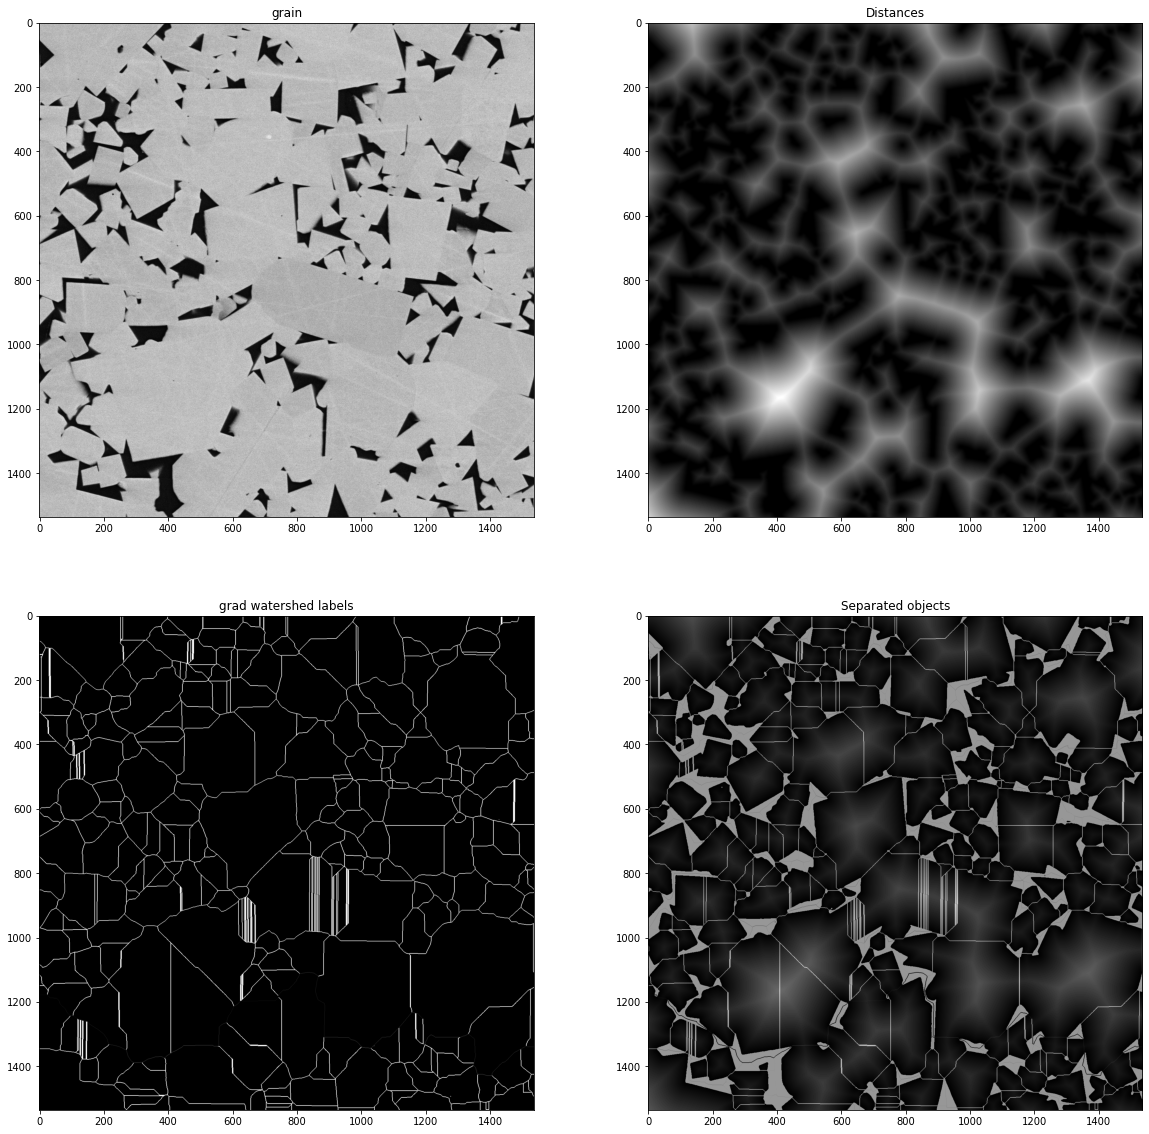

In [19]:
image =grain_images[0]

denoised = filters.rank.median(image, disk(3))
binary = grainPreprocess.do_otsu(denoised).astype('uint8')

distance = ndi.distance_transform_edt(binary).astype('uint8')
distance = filters.gaussian(distance, sigma=2)

distance_copy = copy.copy(distance)

# у функции peak_lcal_max есть баг, что первый параметр он изменяет
# поэтому на вход отправляем копию, чтобы исхдные данные не изменились

coords = peak_local_max(distance_copy, footprint=np.ones((9, 3)), labels=binary).astype('int64')

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

labels = seg.watershed(-distance, markers, mask=image)
labels = labels.astype('uint8')

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('grain')

ax[1].imshow(distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')

grad = abs(filters.rank.gradient(labels, disk(1))).astype('uint8')
ax[2].imshow(grad * 255, cmap=plt.cm.gray)
ax[2].set_title('grad watershed labels')

labels = grad * 255 + (1 - binary) * 255 + distance * 255
ax[3].imshow(labels, cmap='gray')
ax[3].set_title('Separated objects')

plt.show()


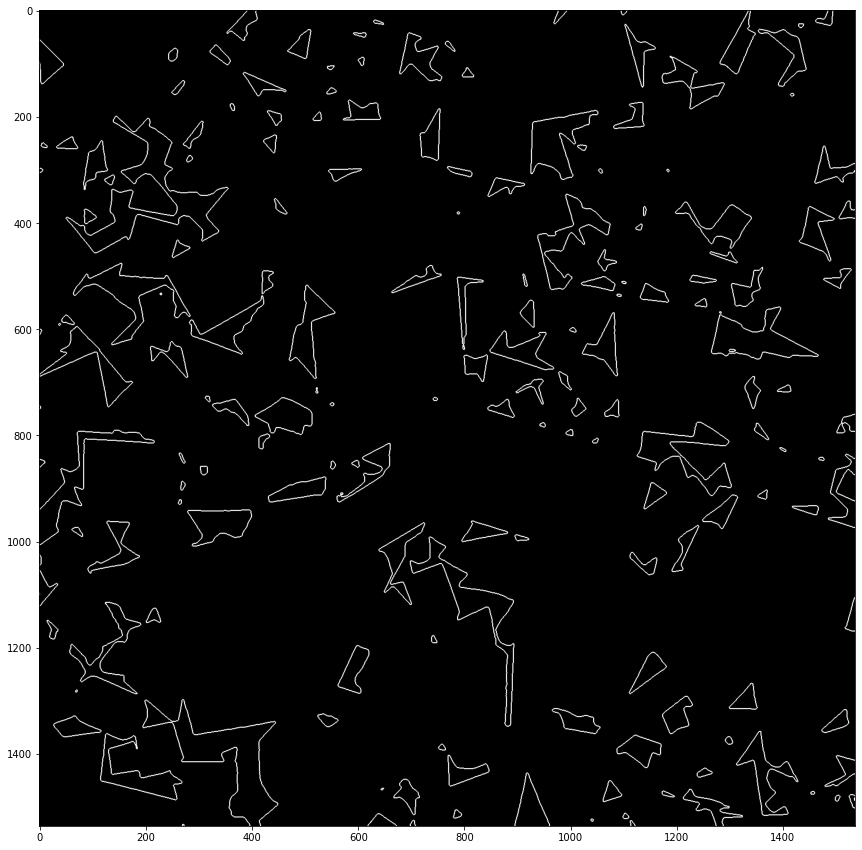

In [20]:
dis_and_grad = grad * 255 + distance * 255
plt.figure(figsize=(15, 15))
binary = grad = abs(filters.rank.gradient(binary, disk(1))).astype('uint8')
plt.imshow(binary,cmap='gray')
plt.show()